### Note: Using this notebook
This notebook walks through the available data, and introduces you to the concepts and tools that you can use in order to prepare, propose, and solve data science problems. Each code cell in this tool can be executed to replicate the results. 

For tips/tricks on using Jupyter Notebooks, please see: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html

In [1]:
import pandas as pd
from glob import glob
import numpy as np

#Let's also get the combined dataset from last week
combined_dataset = pd.read_csv("../Week 4/combined_dataset.csv", index_col = 0)

## Creating Features
Along with a "target" variable. A model also needs features or input variables so that it can learn the relationship between this input variable and the output or "target". 

While the OHLCV (Open-High-Low-Close-Volume) stock data from Yahoo is at a daily cadence, actual earnings and analyst estimates data from Zacks and Estimize are at a quarterly cadence. Hence, we will need to somehow aggregate the stock data to match the granularity of our target. In order to do this we will use the Split-Apply-Combine idiom, where daily data is split into quarterly intervals, aggregation functions are applied repeatedly to all quarters, and the data was finally combined to create features corresponding to earnings data for each quarter. 


### Data Cleaning - Preparing the dataset for feature creation
From the sample of the stock data, we can see that it doesn't have the fiscal year or the fiscal quarter. Our earnings data does have the date corresponding to each quarter earnings and we can use that and backfill. Once we have attached the fiscal date markers to the stock data, we are ready to split, apply and combine.

First, let us read all of the stock data and combine it

In [2]:
stock_files = glob('../Week 3/stocks/*')

In [3]:
all_data = []
for f in stock_files:
    df = pd.read_csv(f, na_values = ["None"])
    #Convert the "date" column from string to date format
    df["date"] = pd.to_datetime(df["date"])
    all_data.append(df)
    
combined_stocks = pd.concat(all_data)

Now, we will concatenate the stocks data and earnings data, in order to get the fiscal year and quarter attached to the stocks data. In order to do this, we will exploit the pandas properties of set index and reindex that allow you to fill missing data

In [4]:
#First, Set the index of the stock data to date and ticker 
combined_stocks["tickdate"] = combined_stocks["ticker"]+combined_stocks["date"].astype(str)
combined_stocks = combined_stocks.set_index(["tickdate"]).sort_index()
combined_stocks.head()

,date,ticker,open,high,low,close,volume
tickdate,,,,,,,
ADBE2000-01-03,2000-01-03,ADBE,16.69,16.76,15.95,16.27,7384400
ADBE2000-01-04,2000-01-04,ADBE,15.64,16.34,14.88,14.91,7813200
ADBE2000-01-05,2000-01-05,ADBE,14.46,15.58,14.46,15.20,14927200
ADBE2000-01-06,2000-01-06,ADBE,15.25,15.55,15.05,15.33,10221200
ADBE2000-01-07,2000-01-07,ADBE,15.28,16.07,15.11,16.07,8253200


In [5]:
#Then, extract a subset of the columns from the earnings data set and set the index to the same
quarter_index = combined_dataset[["date","ticker","fiscal_year","fiscal_quarter"]].copy()
quarter_index["tickdate"] = quarter_index["ticker"]+quarter_index["date"].astype(str)
quarter_index = quarter_index.set_index(["tickdate"]).sort_index().drop("date", axis = 1).drop("ticker", axis = 1)
quarter_index.head()

,fiscal_year,fiscal_quarter
tickdate,,
ADBE2000-02-01,2000,1
ADBE2000-05-01,2000,2
ADBE2000-08-01,2000,3
ADBE2000-11-01,2000,4
ADBE2001-02-01,2001,1


You can see that the current earnings data contains gaps in between Feb 1st and May 1st, we can use the reindex property to blow out the gaps and backfill with the data from the date where it finds a match. 

First, you will see what happens when we reindex without backfill 

In [6]:
#Let's expand the dates with the fiscal year and quarter
quarter_index_filled = quarter_index.reindex(combined_stocks.index)
quarter_index_filled.head(100)

,fiscal_year,fiscal_quarter
tickdate,,
ADBE2000-01-03,NaN,NaN
ADBE2000-01-04,NaN,NaN
ADBE2000-01-05,NaN,NaN
ADBE2000-01-06,NaN,NaN
ADBE2000-01-07,NaN,NaN
ADBE2000-01-10,NaN,NaN
ADBE2000-01-11,NaN,NaN
ADBE2000-01-12,NaN,NaN
ADBE2000-01-13,NaN,NaN


In [7]:
#Let's expand the dates with the fiscal year and quarter (with bacfill)
quarter_index_filled = quarter_index.reindex(combined_stocks.index, method = "bfill")
quarter_index_filled.head(50)

,fiscal_year,fiscal_quarter
tickdate,,
ADBE2000-01-03,2000,1
ADBE2000-01-04,2000,1
ADBE2000-01-05,2000,1
ADBE2000-01-06,2000,1
ADBE2000-01-07,2000,1
ADBE2000-01-10,2000,1
ADBE2000-01-11,2000,1
ADBE2000-01-12,2000,1
ADBE2000-01-13,2000,1


With the backfill, we have the fiscal quarters and years applied to all the timestamps. Now let's combine the datasets, we will see that we now have fiscal year and quarters

In [8]:
combined_stock_and_quarter = pd.concat([combined_stocks,quarter_index_filled], axis = 1).reset_index(drop = True)
combined_stock_and_quarter.head(30)

,date,ticker,open,high,low,close,volume,fiscal_year,fiscal_quarter
0,2000-01-03,ADBE,16.69,16.76,15.95,16.27,7384400,2000,1
1,2000-01-04,ADBE,15.64,16.34,14.88,14.91,7813200,2000,1
2,2000-01-05,ADBE,14.46,15.58,14.46,15.20,14927200,2000,1
3,2000-01-06,ADBE,15.25,15.55,15.05,15.33,10221200,2000,1
4,2000-01-07,ADBE,15.28,16.07,15.11,16.07,8253200,2000,1
5,2000-01-10,ADBE,16.23,16.69,15.79,16.69,10987200,2000,1
6,2000-01-11,ADBE,16.68,16.69,15.48,15.55,9616000,2000,1
7,2000-01-12,ADBE,15.58,15.73,15.33,15.47,8051200,2000,1
8,2000-01-13,ADBE,15.59,16.38,15.58,16.29,5527200,2000,1
9,2000-01-14,ADBE,16.54,16.72,16.29,16.46,5136800,2000,1


### Creating the Features
Selecting the right features is one of the most important steps for generating a good model. When creating features, there are certain challenges that we need to keep in mind:
+ The challenge is to select features that are predictive of the desired target (beat/non-beat).
+ The features chosen should make sense to a human ‘analyst’ (visually be able to make predictions using them)
+ The features chosen should conform to input expectation of the model (i.e. cannot use negative features in Naïve Bayes models, or have null values in Random Forests)

The features can come directly from the data (e.g. quarter, or industry sector) or be engineeered (i.e. created from hypotheses or technical analysis). Examples of engineered features include:
   + Close > Open more than 50% of the time (or % of days close > open)
   + Price above 10 day simple moving average more than 50% of days (or % of days close price is above 10 day sma)
   + Price above 60 day simple moving average more than 50% of days (or % of days close price is above 60 day sma)
   + % of of times daily price or volume went above a threshold
   
   
   
For a first simplistic example of the model, we will create the first two features in the list (the % versions)

#### % of days that close > open

In [9]:
df = combined_stock_and_quarter
#Create the indicator variable for when close was greater than open 
df['upday'] = np.where(df['close'] > df['open'], 1, 0)

#Split-apply-combine
#Use df.groupby to calculate the number of updays
number_of_updays = df.groupby(['ticker','fiscal_year', 'fiscal_quarter'])['upday'].sum()
#Use df.groupby to calculate the number of trading days in each quarter
number_of_trading_days = df.groupby(['ticker','fiscal_year', 'fiscal_quarter']).size()

#Compute the ratio
ratio_updays = number_of_updays/number_of_trading_days

In [10]:
ratio_updays.head(10)

ticker  fiscal_year  fiscal_quarter
ADBE    2000         1                 0.352941
                     2                 0.629032
                     3                 0.421875
                     4                 0.507692
        2001         1                 0.500000
                     2                 0.442623
                     3                 0.437500
                     4                 0.475410
        2002         1                 0.516129
                     2                 0.475410
dtype: float64

#### Is close > open in more than 50% of days

In [11]:
df = combined_stock_and_quarter
#Create the indicator variable for when close was greater than open 
df['upday'] = np.where(df['close'] > df['open'], 1, 0)

#Split-apply-combine
#Use df.groupby to calculate the number of updays
number_of_updays = df.groupby(['ticker','fiscal_year', 'fiscal_quarter'])['upday'].sum()
#Use df.groupby to calculate the number of trading days in each quarter
number_of_trading_days = df.groupby(['ticker','fiscal_year', 'fiscal_quarter']).size()

#Compute the ratio
ratio_updays = number_of_updays/number_of_trading_days

#Use np.where to calculate if the ratio is more than 50% 

#We use 1 to denote that the phenomenon occurs more 
#than 50% of the days and 0 to indicate that it doesn't
upday_50 = np.where(ratio_updays > 0.5, 
                   1, 0)

#Convert numpy array to pd.series
upday_50 = pd.Series(upday_50, ratio_updays.index)




In [12]:
upday_50.head(10)

ticker  fiscal_year  fiscal_quarter
ADBE    2000         1                 0
                     2                 1
                     3                 0
                     4                 1
        2001         1                 0
                     2                 0
                     3                 0
                     4                 0
        2002         1                 1
                     2                 0
dtype: int64

#### % of days that closing price is above 10 day moving average
When applying rolling functions (to calculate the 10 day moving average), 
we need to make sure that the data is sorted 


In [13]:
#Sort the data frame
combined_stock_and_quarter = combined_stock_and_quarter.sort_values(["ticker","date"])



We will create a column that contains the 10 day rolling mean, and store the value
In order to do this, we will group by each ticker (since we only want to consider values for the same stock), 
and then use the pandas rolling() and mean() functions on top of it

In [14]:
#Create the 10 day rolling mean
combined_stock_and_quarter["10day_ma"] = combined_stock_and_quarter.groupby(['ticker'])["close"].rolling(10).mean().reset_index(drop = True)
combined_stock_and_quarter.head(20)

,date,ticker,open,high,low,close,volume,fiscal_year,fiscal_quarter,upday,10day_ma
0,2000-01-03,ADBE,16.69,16.76,15.95,16.27,7384400,2000,1,0,NaN
1,2000-01-04,ADBE,15.64,16.34,14.88,14.91,7813200,2000,1,0,NaN
2,2000-01-05,ADBE,14.46,15.58,14.46,15.20,14927200,2000,1,1,NaN
3,2000-01-06,ADBE,15.25,15.55,15.05,15.33,10221200,2000,1,1,NaN
4,2000-01-07,ADBE,15.28,16.07,15.11,16.07,8253200,2000,1,1,NaN
5,2000-01-10,ADBE,16.23,16.69,15.79,16.69,10987200,2000,1,1,NaN
6,2000-01-11,ADBE,16.68,16.69,15.48,15.55,9616000,2000,1,0,NaN
7,2000-01-12,ADBE,15.58,15.73,15.33,15.47,8051200,2000,1,0,NaN
8,2000-01-13,ADBE,15.59,16.38,15.58,16.29,5527200,2000,1,1,NaN
9,2000-01-14,ADBE,16.54,16.72,16.29,16.46,5136800,2000,1,0,15.824


In [15]:
df = combined_stock_and_quarter
#Create the indicator variable for when close was greater than open 
df['up10day'] = np.where(df['close'] > df['10day_ma'], 1, 0)

#Split-apply-combine
#Use df.groupby to calculate the number of updays
number_of_up10days = df.groupby(['ticker','fiscal_year', 'fiscal_quarter'])['up10day'].sum()
#Use df.groupby to calculate the number of trading days in each quarter
number_of_trading_days = df.groupby(['ticker','fiscal_year', 'fiscal_quarter']).size()

#Compute the ratio
ratio_up10days = number_of_up10days/number_of_trading_days




In [16]:
ratio_up10days.head(10)

ticker  fiscal_year  fiscal_quarter
ADBE    2000         1                 0.382353
                     2                 0.725806
                     3                 0.515625
                     4                 0.615385
        2001         1                 0.435484
                     2                 0.426230
                     3                 0.406250
                     4                 0.311475
        2002         1                 0.580645
                     2                 0.573770
dtype: float64

#### Is the % of days that closing price is above 10 day moving average more than 50%
We can also leverage the calculation that we have already done for ratio_up10days in order to create a new feature for whether or not this phenomenon occured in more than 50% of the days. 

This illustrates that new features are not necessarily created from scratch. Sometimes it makes sense to create a variation of an existing feeature to create a new one


In [17]:
#Use np.where to calculate if the ratio is more than 50% 

#We use 1 to denote that the phenomenon occurs more 
#than 50% of the days and 0 to indicate that it doesn't
upday10_50 = np.where(ratio_up10days > 0.5, 
                   1, 0)

#Convert numpy array to pd.series
upday10_50 = pd.Series(upday10_50, ratio_up10days.index)



In [18]:
upday10_50.head(10)

ticker  fiscal_year  fiscal_quarter
ADBE    2000         1                 0
                     2                 1
                     3                 1
                     4                 1
        2001         1                 0
                     2                 0
                     3                 0
                     4                 0
        2002         1                 1
                     2                 1
dtype: int64

#### % of days that closing price is above 60 day moving average
We use similar code as before to create the equivalent 60 day moving average feature. This illustrates again that varying the parameters of features (10 days vs 60 days) is a way to create new features

In [19]:
#Sort the data frame
combined_stock_and_quarter = combined_stock_and_quarter.sort_values(["ticker","date"])

In [20]:
#Create the 20 day rolling mean
combined_stock_and_quarter["60day_ma"] = combined_stock_and_quarter.groupby(['ticker'])["close"].rolling(60).mean().reset_index(drop = True)

#Merge with the original data frame
df = combined_stock_and_quarter
#Create the indicator variable for when close was greater than open 
df['up60day'] = np.where(df['close'] > df['60day_ma'], 1, 0)

#Split-apply-combine
#Use df.groupby to calculate the number of updays
number_of_up60days = df.groupby(['ticker','fiscal_year', 'fiscal_quarter'])['up60day'].sum()
#Use df.groupby to calculate the number of trading days in each quarter
number_of_trading_days = df.groupby(['ticker','fiscal_year', 'fiscal_quarter']).size()

#Compute the ratio
ratio_up60days = number_of_up60days/number_of_trading_days

ratio_up60days.head(10)


ticker  fiscal_year  fiscal_quarter
ADBE    2000         1                 0.382353
                     2                 0.387097
                     3                 0.906250
                     4                 0.676923
        2001         1                 0.274194
                     2                 0.245902
                     3                 0.718750
                     4                 0.049180
        2002         1                 0.822581
                     2                 0.918033
dtype: float64

#### Is the % of days that closing price is above 20 day moving average more than 50%

As before, we reuse our calculation

In [21]:
#Use np.where to calculate if the ratio is more than 50% 

#We use 1 to denote that the phenomenon occurs more 
#than 50% of the days and 0 to indicate that it doesn't
upday60_50 = np.where(ratio_up60days > 0.5, 
                   1, 0)

#Convert numpy array to pd.series
upday60_50 = pd.Series(upday60_50, ratio_up10days.index)

upday60_50.head(10)

ticker  fiscal_year  fiscal_quarter
ADBE    2000         1                 0
                     2                 0
                     3                 1
                     4                 1
        2001         1                 0
                     2                 0
                     3                 1
                     4                 0
        2002         1                 1
                     2                 1
dtype: int64

#### % of of times daily price or volume went up above a threshold. 

In order to create these features. We will be using daily closing prices and calulating the return, then we will count up the number of days that the closing prices (day over day) were larger than our threshold. 

A key question to ask is what should this threshold be? 

In order to answer this, we must do some exploratory data analysis. This example illustrates how we combine human hypotheses with answers from the data to create features. 

To start, the human hypothesis is that when the stock is rallying (i.e. when the daily returns are high, or the volume is high) we are more likely to see an EPS Beat. Let's dive in

In [22]:
#First, Sort the data frame
combined_stock_and_quarter = combined_stock_and_quarter.sort_values(["ticker","date"])

#Now lets create the daily return and change in volume

#We will use one of the many built in pandas functions to compute this
combined_stock_and_quarter["daily_return"] = combined_stock_and_quarter.groupby(["ticker"])["close"].pct_change()
combined_stock_and_quarter["pct_change_volume"] = combined_stock_and_quarter.groupby(["ticker"])["volume"].pct_change()




Now, let's take a look at what the distribution of returns looks like. In order to do this, we will use a histogram plot and .describe

For the histogram, to get a clearer picture - we will only focus on cases where the daily returns are within 10%

In [23]:
#Create the histogram plot and restrict the plot limits
res = combined_stock_and_quarter["daily_return"].hist(bins = 100).set_xlim(-0.1,0.1)


And do a .describe

In [24]:
combined_stock_and_quarter["daily_return"].describe()

count    145792.000000
mean          0.000737
std           0.032911
min          -0.459820
25%          -0.013072
50%           0.000000
75%           0.013666
max           0.549008
Name: daily_return, dtype: float64

We can see from these two statistics that the daily returns are pretty normally distributed - centered around 0 (and slightly skewed to the left). The summary statistics provided by .describe show that the median is 0. If we want to look at companies providing exceptional daily returns, a good way to do this would be to count up the number of days that the return is above the 75th percentile of this cohort. 


Similarly, for volume:


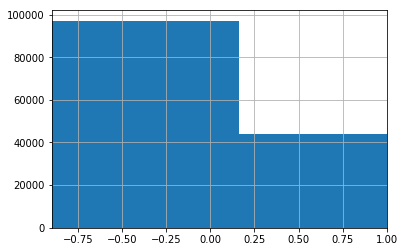

In [25]:
#Create the histogram plot and restrict the plot limits
res = combined_stock_and_quarter["pct_change_volume"].hist(bins = 100).set_xlim(-0.9,1)

In [26]:
combined_stock_and_quarter["pct_change_volume"].describe()

count    145792.000000
mean          0.114047
std           0.832489
min          -0.990660
25%          -0.229873
50%          -0.012826
75%           0.281532
max         114.250000
Name: pct_change_volume, dtype: float64

With volume, its less obvious looking at the histogram distribution to come up with a threshold. However, we can once again use our 75th percentile threshold. Now, let's create the features

In [27]:
#First, we will save our thresholds in variables
daily_return_threshold = 0.013666
daily_volume_change_threshold = 0.281532

In [28]:
#Now, we can use our split-apply-combine idiom to create the features

#Merge with the original data frame
df = combined_stock_and_quarter
#Create the indicator variable for when close was greater than open 
df['up_return'] = np.where(df['daily_return'] > daily_return_threshold, 1, 0)

#Split-apply-combine
#Use df.groupby to calculate the number of updays
number_of_up_return = df.groupby(['ticker','fiscal_year', 'fiscal_quarter'])['up_return'].sum()
#Use df.groupby to calculate the number of trading days in each quarter
number_of_trading_days = df.groupby(['ticker','fiscal_year', 'fiscal_quarter']).size()

#Compute the ratio
ratio_up_return = number_of_up_return/number_of_trading_days

ratio_up_return.head(10)


ticker  fiscal_year  fiscal_quarter
ADBE    2000         1                 0.264706
                     2                 0.483871
                     3                 0.375000
                     4                 0.430769
        2001         1                 0.387097
                     2                 0.311475
                     3                 0.359375
                     4                 0.327869
        2002         1                 0.403226
                     2                 0.327869
dtype: float64

And for volume

In [29]:
#Merge with the original data frame
df = combined_stock_and_quarter
#Create the indicator variable for when close was greater than open 
df['up_volume'] = np.where(df['pct_change_volume'] > daily_volume_change_threshold, 1, 0)

#Split-apply-combine
#Use df.groupby to calculate the number of updays
number_of_up_volume = df.groupby(['ticker','fiscal_year', 'fiscal_quarter'])['up_volume'].sum()
#Use df.groupby to calculate the number of trading days in each quarter
number_of_trading_days = df.groupby(['ticker','fiscal_year', 'fiscal_quarter']).size()

#Compute the ratio
ratio_up_volume = number_of_up_volume/number_of_trading_days

ratio_up_volume.head(10)


ticker  fiscal_year  fiscal_quarter
ADBE    2000         1                 0.264706
                     2                 0.241935
                     3                 0.265625
                     4                 0.230769
        2001         1                 0.209677
                     2                 0.295082
                     3                 0.218750
                     4                 0.245902
        2002         1                 0.241935
                     2                 0.262295
dtype: float64

### Creating the Model Input Table (with Created features).

Now, we have created our features - lets put our input and output data together that we will train the model on. 

As a reminder, we have created features and stored them in the following variables
+ ratio_updays
+ upday_50
+ ratio_up10days
+ upday10_50
+ ratio_up60days
+ upday60_50
+ ratio_up_return
+ ratio_up_volume


In [30]:
training_data = pd.concat([ratio_updays, ratio_up10days, ratio_up60days,
                           upday_50, upday10_50, upday60_50,
                           ratio_up_return, ratio_up_volume], axis = 1)
#When we combine single columns into a data frame, we need to rename the columns of the resulting 

In [31]:
training_data.head(10)

0         1         2  3  4  5  \
ticker fiscal_year fiscal_quarter                                          
ADBE   2000        1               0.352941  0.382353  0.382353  0  0  0   
                   2               0.629032  0.725806  0.387097  1  1  0   
                   3               0.421875  0.515625  0.906250  0  1  1   
                   4               0.507692  0.615385  0.676923  1  1  1   
       2001        1               0.500000  0.435484  0.274194  0  0  0   
                   2               0.442623  0.426230  0.245902  0  0  0   
                   3               0.437500  0.406250  0.718750  0  0  1   
                   4               0.475410  0.311475  0.049180  0  0  0   
       2002        1               0.516129  0.580645  0.822581  1  1  1   
                   2               0.475410  0.573770  0.918033  0  1  1   

                                          6         7  
ticker fiscal_year fiscal_quarter                      
ADBE   2000        1               0.264706  0.264706  
                   2               0.483871  0.241935  
                   3               0.375000  0.265625  
                   4               0.430769  0.230769  
       2001        1               0.387097  0.209677  
                   2               0.311475  0.295082  
                   3               0.359375  0.218750  
                   4               0.327869  0.245902  
       2002        1               0.403226  0.241935  
                   2               0.327869  0.262295

In [32]:
#When we combine single columns into a data frame, we need to rename the columns of the resulting dataframe
training_data = training_data.rename(columns = {0: "ratio_updays", 1:"ratio_up10days", 2: "ratio_up60days",
                                                3: "upday_50", 4:"upday10_50", 5: "upday60_50",
                                                6: "ratio_up_return", 7:"ratio_up_volume"})
training_data.head(10)

ratio_updays  ratio_up10days  \
ticker fiscal_year fiscal_quarter                                 
ADBE   2000        1                   0.352941        0.382353   
                   2                   0.629032        0.725806   
                   3                   0.421875        0.515625   
                   4                   0.507692        0.615385   
       2001        1                   0.500000        0.435484   
                   2                   0.442623        0.426230   
                   3                   0.437500        0.406250   
                   4                   0.475410        0.311475   
       2002        1                   0.516129        0.580645   
                   2                   0.475410        0.573770   

                                   ratio_up60days  upday_50  upday10_50  \
ticker fiscal_year fiscal_quarter                                         
ADBE   2000        1                     0.382353         0           0   
                   2                     0.387097         1           1   
                   3                     0.906250         0           1   
                   4                     0.676923         1           1   
       2001        1                     0.274194         0           0   
                   2                     0.245902         0           0   
                   3                     0.718750         0           0   
                   4                     0.049180         0           0   
       2002        1                     0.822581         1           1   
                   2                     0.918033         0           1   

                                   upday60_50  ratio_up_return  \
ticker fiscal_year fiscal_quarter                                
ADBE   2000        1                        0         0.264706   
                   2                        0         0.483871   
                   3                        1         0.375000   
                   4                        1         0.430769   
       2001        1                        0         0.387097   
                   2                        0         0.311475   
                   3                        1         0.359375   
                   4                        0         0.327869   
       2002        1                        1         0.403226   
                   2                        1         0.327869   

                                   ratio_up_volume  
ticker fiscal_year fiscal_quarter                   
ADBE   2000        1                      0.264706  
                   2                      0.241935  
                   3                      0.265625  
                   4                      0.230769  
       2001        1                      0.209677  
                   2                      0.295082  
                   3                      0.218750  
                   4                      0.245902  
       2002        1                      0.241935  
                   2                      0.262295

In [33]:
#Finally, let's add our "beat" target to the dataframe
target = combined_dataset[["ticker","fiscal_year","fiscal_quarter","beat"]].copy().set_index(["ticker","fiscal_year","fiscal_quarter"])
target.head(10)

beat
ticker fiscal_year fiscal_quarter      
FFIV   2014        4                  1
                   3                  1
                   2                  1
                   1                  1
       2013        4                  1
                   3                  1
                   2                  0
                   1                  0
       2012        4                  0
                   3                  0

In [34]:
training_data_with_target = pd.concat([training_data, target], axis = 1)
training_data_with_target.head(20)

ratio_updays  ratio_up10days  \
ticker fiscal_year fiscal_quarter                                 
ADBE   2000        1                   0.352941        0.382353   
                   2                   0.629032        0.725806   
                   3                   0.421875        0.515625   
                   4                   0.507692        0.615385   
       2001        1                   0.500000        0.435484   
                   2                   0.442623        0.426230   
                   3                   0.437500        0.406250   
                   4                   0.475410        0.311475   
       2002        1                   0.516129        0.580645   
                   2                   0.475410        0.573770   
                   3                   0.390625        0.265625   
                   4                   0.523077        0.538462   
       2003        1                   0.540984        0.573770   
                   2                   0.548387        0.709677   
                   3                   0.500000        0.453125   
                   4                   0.593750        0.765625   
       2004        1                   0.442623        0.475410   
                   2                   0.476190        0.619048   
                   3                   0.500000        0.516129   
                   4                   0.646154        0.846154   

                                   ratio_up60days  upday_50  upday10_50  \
ticker fiscal_year fiscal_quarter                                         
ADBE   2000        1                     0.382353       0.0         0.0   
                   2                     0.387097       1.0         1.0   
                   3                     0.906250       0.0         1.0   
                   4                     0.676923       1.0         1.0   
       2001        1                     0.274194       0.0         0.0   
                   2                     0.245902       0.0         0.0   
                   3                     0.718750       0.0         0.0   
                   4                     0.049180       0.0         0.0   
       2002        1                     0.822581       1.0         1.0   
                   2                     0.918033       0.0         1.0   
                   3                     0.140625       0.0         0.0   
                   4                     0.276923       1.0         1.0   
       2003        1                     0.803279       1.0         1.0   
                   2                     0.806452       1.0         1.0   
                   3                     0.531250       0.0         0.0   
                   4                     0.906250       1.0         1.0   
       2004        1                     0.163934       0.0         0.0   
                   2                     0.539683       0.0         1.0   
                   3                     0.725806       0.0         1.0   
                   4                     0.846154       1.0         1.0   

                                   upday60_50  ratio_up_return  \
ticker fiscal_year fiscal_quarter                                
ADBE   2000        1                      0.0         0.264706   
                   2                      0.0         0.483871   
                   3                      1.0         0.375000   
                   4                      1.0         0.430769   
       2001        1                      0.0         0.387097   
                   2                      0.0         0.311475   
                   3                      1.0         0.359375   
                   4                      0.0         0.327869   
       2002        1                      1.0         0.403226   
                   2                      1.0         0.327869   
                   3                      0.0         0.281250   
                   4                      0.0      

Let's save this DataSet for use next week

In [35]:
training_data_with_target.to_csv("full_data_with_features.csv")